The purpose of this notebook is to look at specific images for which the brain mask ended up looking wrong (by visual inspection) and to tweak parameters to get it right. The script `05.1_dti_fit.py` was run first to generate a family of brain masks, DTI fits, and FA images.

This notebook ends with a conclusion that using bvalue=0 images only makes sense for computing brain mask.

In [1]:
import os
import glob
import random
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import dipy.io.image
import dipy.io
import dipy.core.gradients
import dipy.reconst.dti
import dipy.segment.mask

In [4]:
data_dir = 'DMRI_EXTRACTED_NONTEST/'
img_dirs = glob.glob(os.path.join(data_dir,'*ABCD-MPROC-DTI*/sub-*/ses-*/dwi/'))

In [5]:
sampled_fmriresults01_df = pd.read_csv('01.1_abcd_sample2/sampled_nontest_fmriresults01.csv')
sampled_fmriresults01_df['dirname'] = sampled_fmriresults01_df.derived_files.apply(lambda x : x.split('/')[-1].strip('.tgz'))
dirname_to_full_path = {img_dir.split('/')[-5]:img_dir for img_dir in img_dirs}

In [6]:
data = []
for (subjectkey,interview_age),df in sampled_fmriresults01_df.groupby(['subjectkey', 'interview_age']):
    paths = []
    for _,row in df.iterrows():
        if row.dirname not in dirname_to_full_path.keys():
            raise FileNotFoundError(f"Could not find a directory for fmriresults01 id {row.fmriresults01_id}")
        img_dir = dirname_to_full_path[row.dirname]
        dwi_path = glob.glob(os.path.join(img_dir, '*.nii'))[0]
        bval_path = glob.glob(os.path.join(img_dir, '*.bval'))[0]
        bvec_path = glob.glob(os.path.join(img_dir, '*.bvec'))[0]
        paths.append({
            'img_dir' : img_dir,
            'dwi_path' : dwi_path,
            'bval_path' : bval_path,
            'bvec_path' : bvec_path,
        })
    data.append({
        'paths' : paths,

        'subjectkey' : row.subjectkey,
        'interview_age' : row.interview_age,
    })

In [7]:
# Run this to look at the number of bvals for each image, alongside subject id and interview age

for d in data:
    for i,p in enumerate(d['paths']):
        bvals, bvecs = dipy.io.read_bvals_bvecs(p['bval_path'], p['bvec_path'])
        print(f"{len(bvals)} \t {d['subjectkey']} \t {d['interview_age']}",
              f"(part {i+1} of {len(d['paths'])})" if len(d['paths'])>1 else "")

51 	 NDAR_INV014RTM1V 	 137 (part 1 of 2)
51 	 NDAR_INV014RTM1V 	 137 (part 2 of 2)
103 	 NDAR_INV0182J779 	 111 
103 	 NDAR_INV03BDCNWM 	 115 
103 	 NDAR_INV07RPB2TU 	 143 
103 	 NDAR_INV07UK1DPH 	 126 
103 	 NDAR_INV0A87RKWD 	 125 
51 	 NDAR_INV0E1RBR9J 	 147 (part 1 of 2)
51 	 NDAR_INV0E1RBR9J 	 147 (part 2 of 2)
103 	 NDAR_INV0GVW93X6 	 112 
104 	 NDAR_INV0XU7Z6RH 	 139 
104 	 NDAR_INV1MHAP6AR 	 110 
103 	 NDAR_INV1P29RX5F 	 112 
51 	 NDAR_INV1VM14D0X 	 149 (part 1 of 2)
51 	 NDAR_INV1VM14D0X 	 149 (part 2 of 2)
103 	 NDAR_INV27NJ4UJ7 	 126 
103 	 NDAR_INV29XU24ER 	 123 
103 	 NDAR_INV2KZR1A9A 	 110 
104 	 NDAR_INV2NV4C2CL 	 140 
103 	 NDAR_INV2R0HFJ5Y 	 119 
103 	 NDAR_INV2T7FRKV1 	 148 
103 	 NDAR_INV34HCN2RW 	 122 
103 	 NDAR_INV35KNHNNM 	 153 
51 	 NDAR_INV36TXKJEW 	 117 (part 1 of 2)
51 	 NDAR_INV36TXKJEW 	 117 (part 2 of 2)
103 	 NDAR_INV3CJ9GXRL 	 110 
103 	 NDAR_INV3E6J6JJR 	 113 
103 	 NDAR_INV3E7ZYR64 	 112 
103 	 NDAR_INV3H81JJ1U 	 153 
51 	 NDAR_INV41U1CNA9 	 120 (part 

In [15]:
# Function to load data from one of the dictionaries listed in the object "data" defined above
def load_data(d):
    img_data_list =[]
    bvals_list = []
    bvecs_list = []
    prev_affine_transform = None

    for p in d['paths']:
        img_data, affine = dipy.io.image.load_nifti(p['dwi_path'])
        assert((prev_affine_transform is None) or (affine==prev_affine_transform).all())
        prev_affine_transform = affine  
        bvals, bvecs = dipy.io.read_bvals_bvecs(p['bval_path'], p['bvec_path'])
        img_data_list.append(img_data)
        bvals_list.append(bvals)
        bvecs_list.append(bvecs)
        bvals = np.concatenate(bvals_list)
    img_data = np.concatenate(img_data_list, axis=-1)
    bvecs = np.concatenate(bvecs_list, axis=0)
    gtab = dipy.core.gradients.gradient_table(bvals, bvecs)
    return img_data, affine, gtab

In [86]:
data_indexed_by_subject = {d['subjectkey']:d for d in data}

d_random = random.choice(data) # Pick a random one

# pick ones for which the brain mask was observed problematic
d_badmask1 = data_indexed_by_subject['NDAR_INV87T95RHP']
d_badmask2 = data_indexed_by_subject['NDAR_INVE0KZKF5V']
d_badmask3 = data_indexed_by_subject['NDAR_INVGL5PNTK7']
d_badmask4 = data_indexed_by_subject['NDAR_INVWAC9RH98']

img_data, affine, gtab = load_data(d_badmask1) # Load one to demonstrate how we process it below

Generate brain mask and preview it for the loaded image:

In [87]:
img_data_masked, mask = dipy.segment.mask.median_otsu(img_data, vol_idx = range(img_data.shape[-1]))

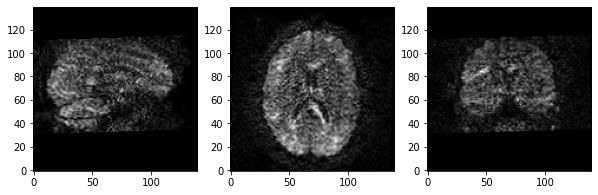

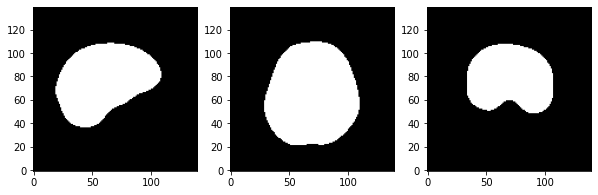

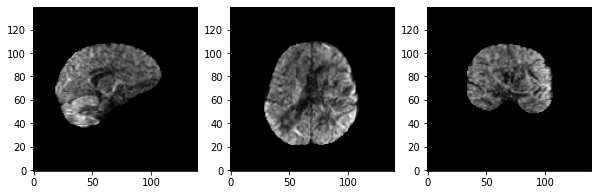

In [223]:
def preview(img):
    fig,axs = plt.subplots(1,3,figsize=(10,5))
    axs[0].imshow(img[62,:,:].T, origin='lower', cmap='gray')
    axs[1].imshow(img[:,:,80].T, origin='lower', cmap='gray')
    axs[2].imshow(img[:,75,:].T, origin='lower', cmap='gray')
    plt.show()

num_bvals = img_data.shape[3]
i = random.randint(0,num_bvals-1)
preview(img_data[:,:,:,i])
preview(mask)
preview(img_data_masked[:,:,:,i])

Try again with different parameters on the otsu thresholding:

In [224]:
img_data_masked, mask = dipy.segment.mask.median_otsu(img_data, vol_idx = [0], median_radius=4, numpass=4)

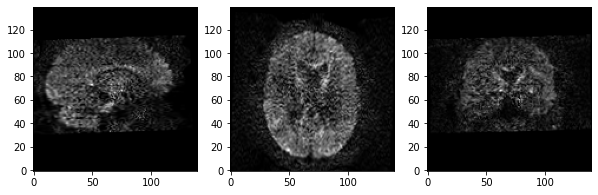

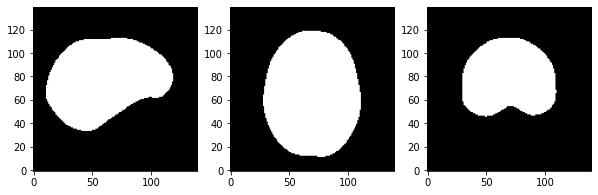

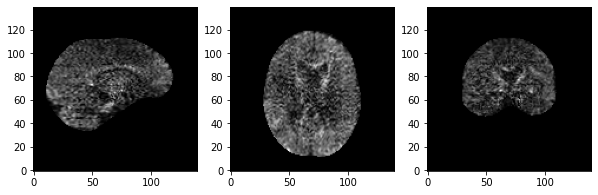

In [225]:
num_bvals = img_data.shape[3]
i = random.randint(0,num_bvals-1)
preview(img_data[:,:,:,i])
preview(mask)
preview(img_data_masked[:,:,:,i])

In the end, instead of tweaking the median filtering, it seems that focusing on the image for a specific bvalue, rather than all bvalues, helped the most. Picking the bvalue that has the least noisy image for mask generation seems to be the way to go. Let's inspect if there's a consistent best b-value for this purpose:

In [226]:
img_data, affine, gtab = load_data(random.choice(data)) # Load random subject
num_bvals = img_data.shape[3]

Image with bvalue 0.0:


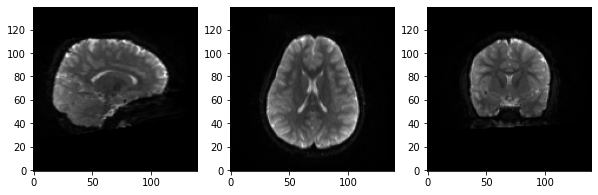

Image with bvalue 500.0:


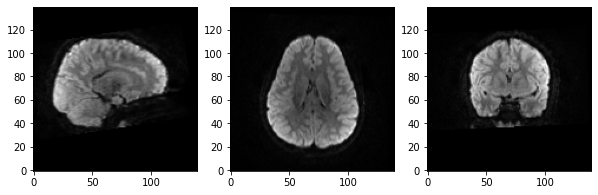

Image with bvalue 1000.0:


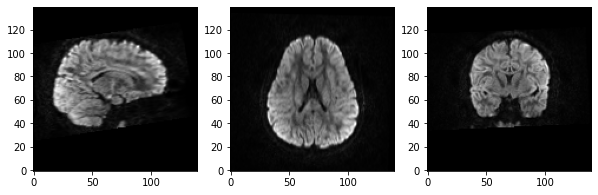

Image with bvalue 2000.0:


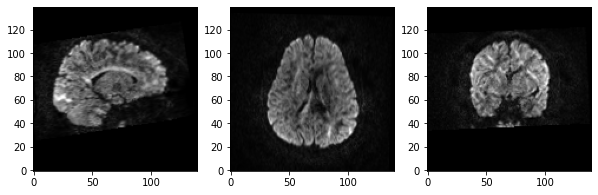

Image with bvalue 3000.0:


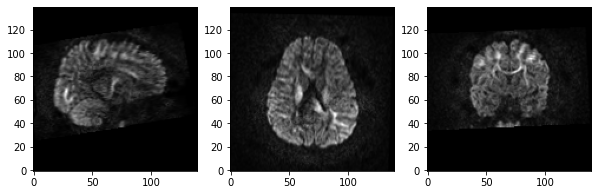

In [227]:
for b in np.unique(gtab.bvals):
    i = random.choice(np.where(gtab.bvals==b)[0])
    print(f"Image with bvalue {gtab.bvals[i]}:")
    preview(img_data[:,:,:,i])

Running this cell a few times, the b-value 0 images (i.e. the ones that aren't diffusion weighted are clearly best to use for masking. This makes sense, because

> image contrast increases at higher b-values, albeit at the cost of reduced SNR

(from https://doi.org/10.1016/B978-0-12-817057-1.00022-6)

and while SNR and contrast both matter for accuracy of otsu thresholding-- here it's SNR that is our limiting factor, rather than contrast.

Let's now try using bval 0 only in the mask generation:

In [230]:
img_data, affine, gtab = load_data(d_badmask1) # Load one to demonstrate how we process it below
img_data_masked, mask = dipy.segment.mask.median_otsu(img_data, vol_idx = np.where(gtab.bvals==0)[0])

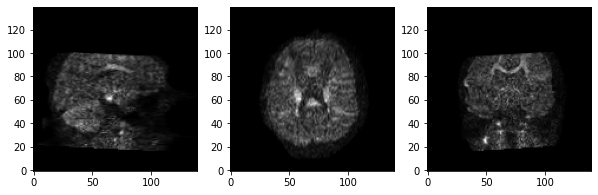

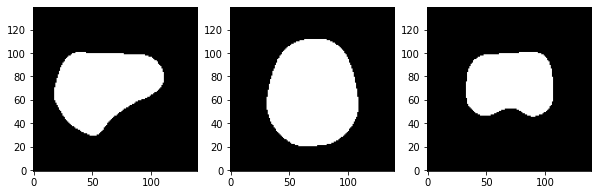

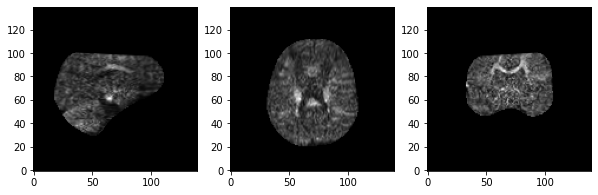

In [231]:
num_bvals = img_data.shape[3]
i = random.randint(0,num_bvals-1)
preview(img_data[:,:,:,i])
preview(mask)
preview(img_data_masked[:,:,:,i])